In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Scaler
from sklearn.preprocessing import StandardScaler

# Model Selection
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# disable warnings
import warnings
warnings.simplefilter('ignore')

In [4]:
# Put functions her
def import_train_data(train_data_file):
    """
    Import Training data set
    :param train_data_file <str>: Path to Training data set file in tsv format
    :return <pd.DataFrame>: Training data set
    """

    df = pd.read_table(train_data_file, index_col=0)
    columns = ['outcome', 'IL-1b', 'IL-6', 'TNF-a', 'CXCL9', 'CXCL10', 'CXCL11',
               'IFN-lambda', 'IL-8', 'IL-12p70', 'IFN-a', 'IL-28', 'GM-CSF', 
                'IFN-b', 'IL-10', 'IFN-g']

    df.columns = columns

    df.dropna(axis=0, inplace=True)

    # exclude Healthy Patient Samples from Dataset
    df = df[df['outcome'] != 'Healthy']

    # outcome values to bool
    df['outcome'] = df['outcome'] == 'Streptococcus pyogenes'
    
    return df


def get_Xy(df_raw, outcome_feature, selected_features=None, standard_scale=False):
    """
    Get feature matrix and target vector from Dataframe
    :param df_raw <pd.DataFrame>:
    :param outcome_feature <str>: Name of target variable columns
    :param selected_features <list>: Specify to select a subset of features
    :param standard_scale <bool>: Standard scale data
    :return <tuple>: feature matrix <np.array>, target vector <np.array>
    """
    
    df = df_raw.copy()
    df.dropna(axis=0, inplace=True)
    
    y =  np.array(df.loc[:, outcome_feature])
    
    if selected_features:
        X = df.loc[:, selected_features]
    else:
        X = df.drop(outcome_feature, axis=1)
    
    if standard_scale == True:
        X = StandardScaler().fit_transform(X)
    
    X = np.array(X)
    
    return X, y


#def confusion_report(model, X_test, y_test):
#    y_pred = model.predict(X_test)
#    y_test = np.array(y_test)
#    print(classification_report(y_test, y_pred))
#    tab = pd.crosstab(y_test, y_pred,  margins=True, rownames=['Condition'], colnames=['Predicted'])
#    return tab


def do_GridCVSearch(X, y, classifier, param_grid, cv=None, scores=None):
    """
    Get cross-validated GridSearch reports
    :param X <np.array>: feature matrix
    :param y <np.array>: target vector
    :param param_grid <dict>: grid of parameters
    :param cv <cross validator object>: Initialized cross validator
    :param scores <list>: performance metrics (default: Precision, Recall)
    :return <dict>: {score: cv_results}
    """
    
    if not cv:
        cv = RepeatedStratifiedKFold(n_repeats=5, n_splits=2, random_state=random_state)

    if not scores:
        scores = ['precision', 'recall']

    grid_scores = dict()
    for score in scores:
        print(f'Tuning Hyper parameters for {score}\n')

        grid = GridSearchCV(classifier, 
                            param_grid=param_grid, cv=cv, 
                            #scoring=f'{score}_macro',
                            verbose=2, n_jobs=-1)
        grid.fit(X, y)

        print("Best parameters set found on development set:\n")
        print(grid.best_params_, '\n')

        print("Detailed classification report:\n")
        print("The model is trained on the full development set.")
        print("The scores are computed on the full evaluation set.\n")

        grid_scores[score] = grid.cv_results_

    return grid_scores


def plot_GridSearch(grid_scores):
    """
    Plot grid search results
    :param grid_scores <dict>: {score: cv_results}
    """
    
    plt.style.use('ggplot')
    fig, axes = plt.subplots(len(grid_scores), 1, figsize=(20, 10))
    param_names = None
    for i, score in enumerate(grid_scores):
        
        if not param_names:
            df_grid = pd.DataFrame.from_dict(grid_scores[score]['params'], dtype=str)
            param_names = list(df_grid.columns)
            df_grid['label'] = df_grid[param_names].apply(lambda x: '-'.join(x), axis=1)
            ind = np.arange(df_grid.shape[0])
        
        df_grid['{}_mean'.format(score)] = grid_scores[score]['mean_test_score']
        df_grid['{}_std'.format(score)] = grid_scores[score]['std_test_score']
        top_params = df_grid.sort_values('{}_mean'.format(score), ascending=False).index[:5]
        colors = ['#E24A33' if i in top_params else '#348ABD' for i in ind]
        axes[i].bar(ind, df_grid['{}_mean'.format(score)], yerr=df_grid['{}_std'.format(score)], color=colors)
        axes[i].set_title(score.upper())

    plt.xticks(ind, df_grid['label'], rotation='vertical')
    #plt.title('RECALL')
    plt.show()

# Cross Validation
- Repeated Stratified 

In [6]:
# raw data import
train_data_file = '../data/fig7/train_data_all_markers.tsv'

#import data
df_train = import_train_data(train_data_file)

feature_sets = {'Full Panel': ['IL-1b', 'IL-6', 'TNF-a', 'CXCL9', 'CXCL10', 'CXCL11', 'IFN-lambda', 'IL-8', 'IL-12p70', 'IFN-a', 'IL-28', 'GM-CSF', 'IFN-b', 'IL-10', 'IFN-g'],
                'Sparse Panel': ['CXCL10', 'CXCL9', 'CXCL11']}

random_state = 42
repeats = 10

# GridSearch: RF

Tuning Hyper parameters for f1

Fitting 20 folds for each of 24 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   26.9s
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:   35.1s finished


Best parameters set found on development set:

{'max_features': 'sqrt', 'min_samples_leaf': 3, 'n_estimators': 250} 

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

Tuning Hyper parameters for precision

Fitting 20 folds for each of 24 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:   28.9s finished


Best parameters set found on development set:

{'max_features': 'sqrt', 'min_samples_leaf': 3, 'n_estimators': 250} 

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

Tuning Hyper parameters for recall

Fitting 20 folds for each of 24 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   26.2s
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:   34.9s finished


Best parameters set found on development set:

{'max_features': 'sqrt', 'min_samples_leaf': 3, 'n_estimators': 250} 

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.



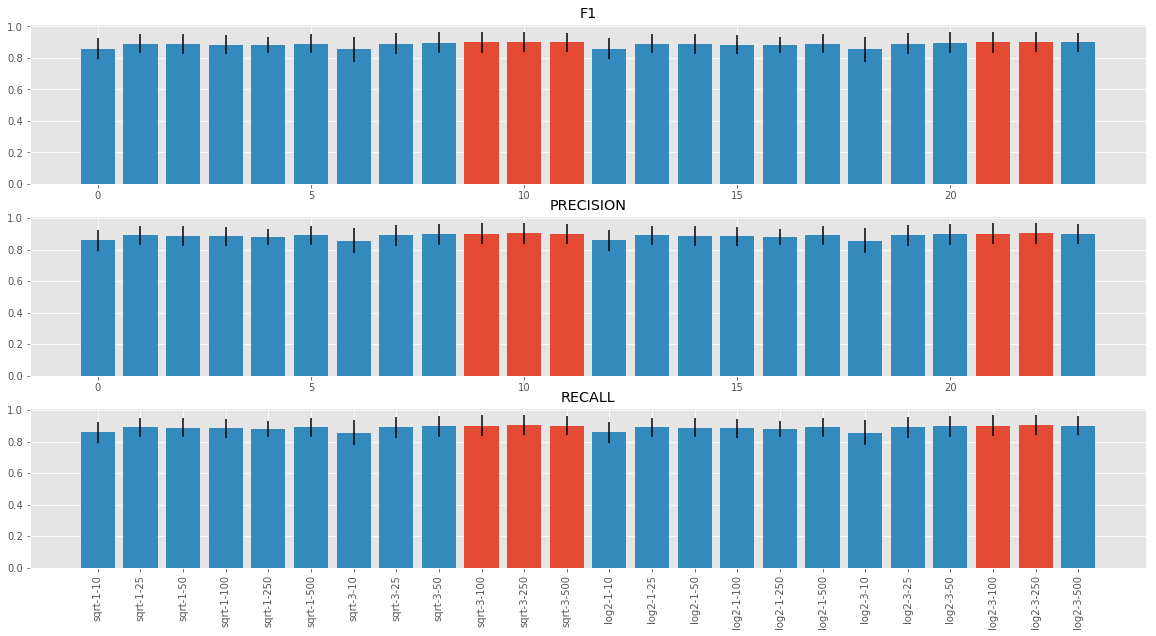

In [5]:
rf_grid = {'n_estimators': [10, 25, 50, 100, 250, 500],
           'min_samples_leaf': [1, 3],
           'max_features': ['sqrt', 'log2']}

#full dataset
X, y = get_Xy(df_train, 'outcome', selected_features=feature_sets['Full Panel'], standard_scale=False)
cv = RepeatedStratifiedKFold(n_repeats=repeats, n_splits=2, random_state=random_state)
classifier = RandomForestClassifier(n_jobs=-1, random_state=random_state)

grid_scores = do_GridCVSearch(X, y, classifier, rf_grid, cv=cv, scores=['f1', 'precision', 'recall'])
plot_GridSearch(grid_scores)

## BEST PARAMETERS (RF)
- model parameters were chosen from the combination of top 5 best parameters in RECALL, PRECISION and F1 score
- 'max_depth':         25
- 'min_samples_leaf':   3
- 'n_estimators':     250

# GridSearch: SVC

Tuning Hyper parameters for recall

Fitting 20 folds for each of 100 candidates, totalling 2000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 142 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters set found on development set:

{'C': 1.6681005372000592, 'gamma': 0.01} 

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

Tuning Hyper parameters for precision

Fitting 20 folds for each of 100 candidates, totalling 2000 fits


[Parallel(n_jobs=-1)]: Done 610 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:    0.6s finished


Best parameters set found on development set:

{'C': 1.6681005372000592, 'gamma': 0.01} 

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.



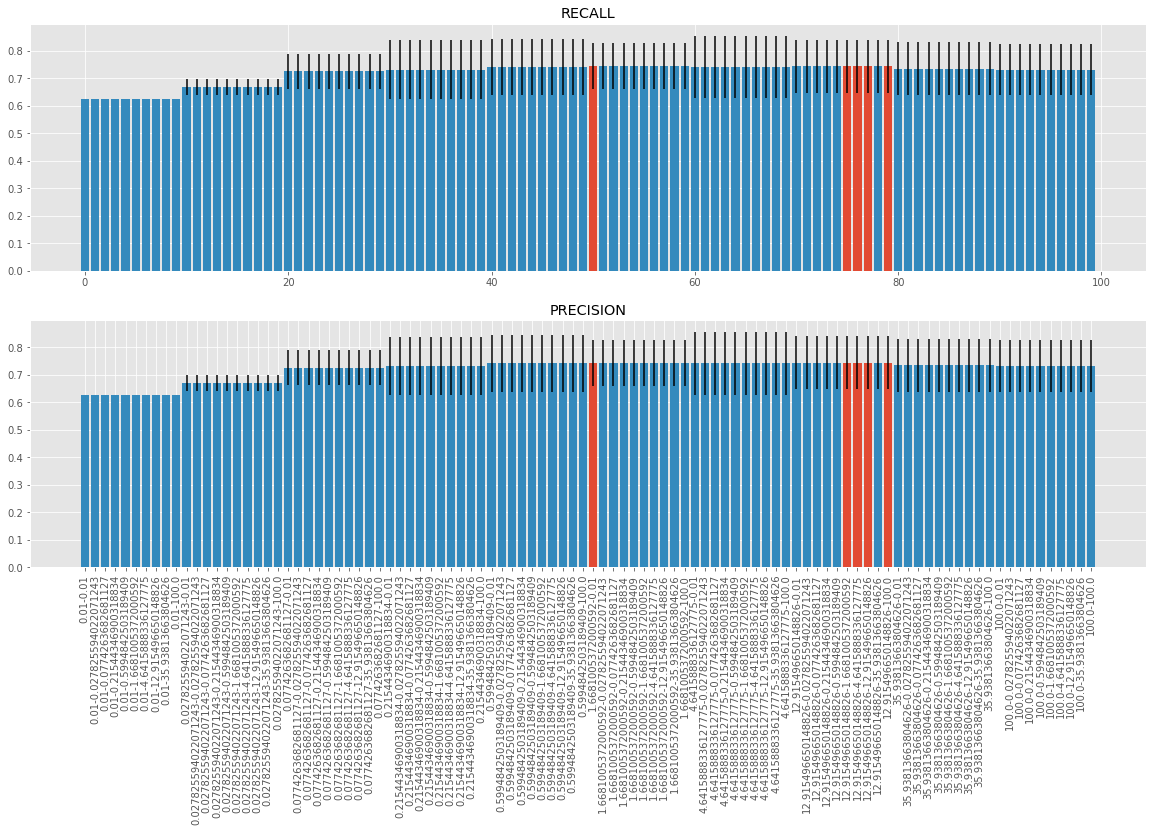

In [16]:
svc_grid = {'C': np.logspace(-2, 2, 10),
           'gamma':np.logspace(-2, 2, 10)}

#full dataset
X, y = get_Xy(df_train, 'outcome', selected_features=feature_sets['Full Panel'], standard_scale=True)
cv = RepeatedStratifiedKFold(n_repeats=repeats, n_splits=2, random_state=random_state)
classifier = SVC(kernel='linear', random_state=random_state)

grid_scores = do_GridCVSearch(X, y, classifier, svc_grid, cv=cv, scores=['recall', 'precision'])
plot_GridSearch(grid_scores)

# BEST PARAMETERS (linear SVM Classifier)
- SVC is trained on __StandardScaled__ Data
- parameters were selected based on Recall score from the from the combination of top 5 best parameters 
    (gamma has only a minor influence on performance and is set to 1)
    - C: 10
    - gamma: 1

# GridSearch: Logistic Regression

In [8]:
np.logspace(-10, 0, 10)

array([1.00000000e-10, 1.29154967e-09, 1.66810054e-08, 2.15443469e-07,
       2.78255940e-06, 3.59381366e-05, 4.64158883e-04, 5.99484250e-03,
       7.74263683e-02, 1.00000000e+00])

Tuning Hyper parameters for f1

Fitting 20 folds for each of 28 candidates, totalling 560 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 560 out of 560 | elapsed:   11.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters set found on development set:

{'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'} 

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

Tuning Hyper parameters for precision

Fitting 20 folds for each of 28 candidates, totalling 560 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 560 out of 560 | elapsed:    8.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters set found on development set:

{'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'} 

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

Tuning Hyper parameters for recall

Fitting 20 folds for each of 28 candidates, totalling 560 fits


[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 560 out of 560 | elapsed:   10.8s finished


Best parameters set found on development set:

{'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'} 

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.



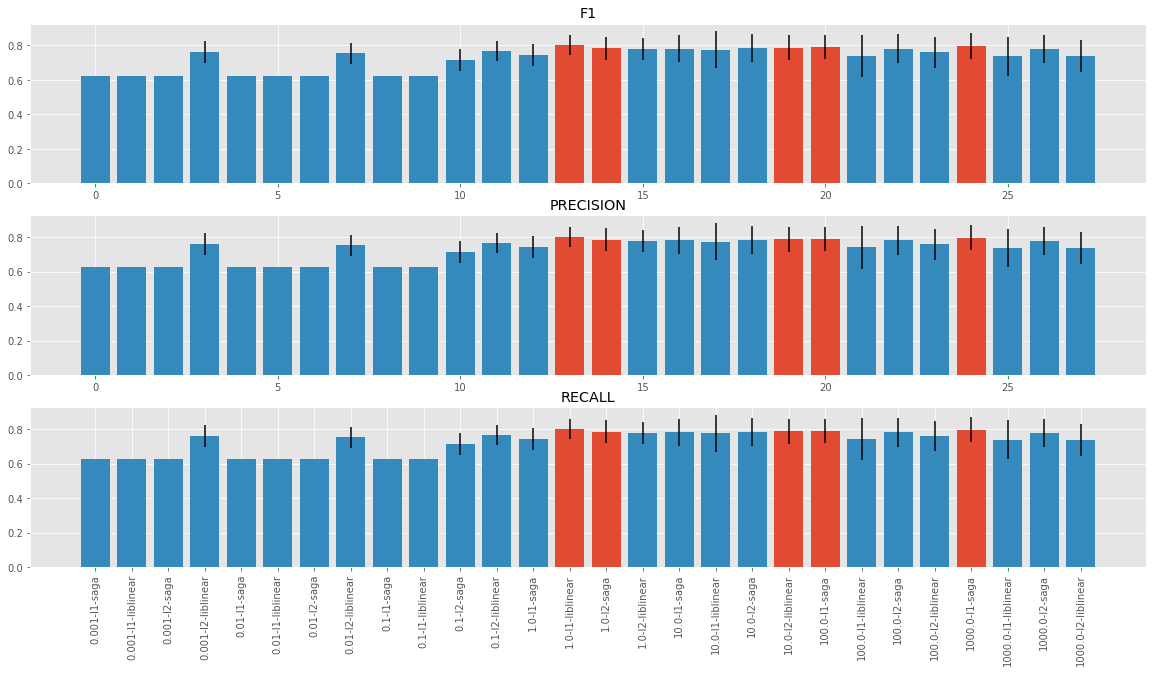

In [9]:
logReg_grid = {'penalty': ['l1', 'l2'],
               'C': np.logspace(-3,3,7),
               'solver': ['saga', 'liblinear']
              }
#full dataset
X, y = get_Xy(df_train, 'outcome', selected_features=feature_sets['Full Panel'], standard_scale=True)
#X, y = get_Xy(df_train, 'outcome', selected_features=feature_sets['Full Panel'], standard_scale=False)
cv = RepeatedStratifiedKFold(n_repeats=repeats, n_splits=2, random_state=random_state)
classifier = LogisticRegression(solver='saga', n_jobs=-1, random_state=random_state)

grid_scores = do_GridCVSearch(X, y, classifier, logReg_grid, cv=cv, scores=['f1', 'precision', 'recall'])
plot_GridSearch(grid_scores)

# BEST PARAMETERS (LogReg)

- model parameters were chosen from the combination of top 5 best parameters in RECALL, PRECISION and F1 score
    - 'C': 1
    - 'penalty': 'L2'

In [ ]:
best_params = {'rf': {'max_depth': 25, 'min_samples_leaf': 3, 'n_estimators': 250},
               'svc': {'C': 10.0, 'gamma': 1},
               'logReg': {'C': 1, 'penalty': 'l2', 'solver': 'saga'}
              }